In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
install.packages("gridExtra")
library(gridExtra)


# Is it possible to evaluate students' knowledge based on their exam scores and study habits?

## Introduction with the preliminary exploratory data analysis

Understanding the factors that influence student performance is critical for effective teaching and learning in the field of education. In order to group students into study knowledge levels, our study will examine student performance data and develop a predictive model. This analysis will help teachers better tailor their curriculum to suit the requirements of their students. Knowing how studying habits and their exam scores relate to their knowledge, can help teachers adapt in their methods in the way they evaluate students.  

We are using [User Knowledge](https://archive.ics.uci.edu/dataset/257/user+knowledge+modeling) data taken from the UC Irvine database. It is measuring students' knowledge of Electrical DC Machines. Our research question is as follows : Is it possible to predict students' knowledge based on their exam scores and study time?


In [2]:
url <- "https://raw.githubusercontent.com/naomi-ng/DSCI100-project/main/user_experience.csv"
user_experience_data <- read_csv(url, col_names = c("study_time_goal", "repetition_goal", "study_related", 
                                                   "exam_performance_related", "exam_performance_goal", "knowledge"), 
                                skip = 1)
                                 
tidy_ux_data <- user_experience_data |>
    select(-X7, -X8, -X9) |>
    mutate(knowledge = as_factor(knowledge)) |>
    mutate(study_time_goal = study_time_goal * 10) |>
    mutate(repetition_goal = repetition_goal * 10) |>
    mutate(study_related = study_related * 10) |>
    mutate(exam_performance_related = exam_performance_related * 10) |>
    mutate(exam_performance_goal = exam_performance_goal * 10)|>
    mutate(knowledge = fct_recode(knowledge, "Very Low" = "very_low"))

    
                                 
head(tidy_ux_data)  
tail(tidy_ux_data)                 

Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): knowledge, X9
dbl (5): study_time_goal, repetition_goal, study_related, exam_performance_r...
lgl (2): X7, X8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0,0.0,0.0,0.0,0.0,Very Low
0.8,0.8,1.0,2.4,9.0,High
0.6,0.6,0.5,2.5,3.3,Low
1.0,1.0,1.5,6.5,3.0,Middle
0.8,0.8,0.8,9.8,2.4,Low
0.9,1.5,4.0,1.0,6.6,Middle


study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.4,5.1,5.5,6.4,1.9,Low
6.1,7.8,6.9,9.2,5.8,High
7.8,6.1,7.1,1.9,6.0,Middle
5.4,8.2,7.1,2.9,7.7,High
5.0,7.5,8.1,6.1,2.6,Middle
6.6,9.0,7.6,8.7,7.4,High


Predictor variables are as follows
- STG (study time for goal object materials)
- SCG (The degree of repetition number of user for goal object materials)
- STR (The degree of study time of user related objects with goal object)
- LPR (The exam performance of user related objects with goal object)
- PEG (exam performance of user for goal objects)

The dataset consists of 403 instances, and the knowledge levels are categorized into 4 levels which are as follows (Very low, low, middle, and high). For our data analysis, we will be using STG and PEG as the predictor variables, as they directly correlate to goal object materials. 


In [3]:
num_obs <- tidy_ux_data |>
    group_by(knowledge) |>
    summarize(counts = n())
num_obs

predictor_means <- tidy_ux_data |>
    summarize(across(study_time_goal:exam_performance_goal, mean))
predictor_means



knowledge,counts
<fct>,<int>
Very Low,24
High,63
Low,83
Middle,88


study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.711473,3.556744,4.680039,4.327132,4.585388


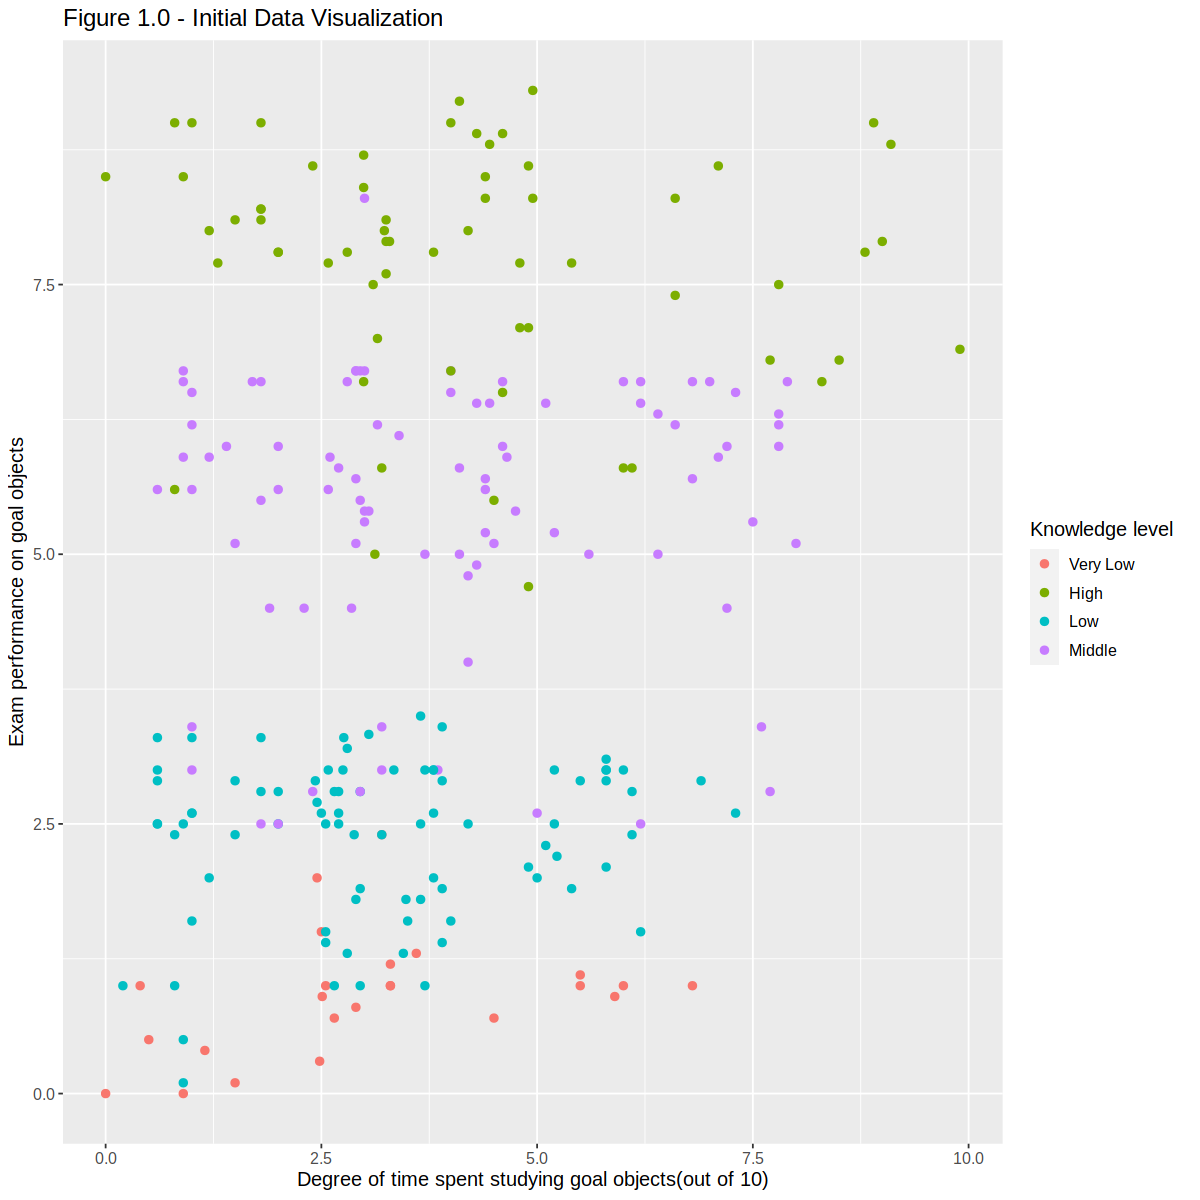

In [15]:
options(repr.plot.width = 10, repr.plot.height = 10) 
ux_plot_initial <- ggplot(tidy_ux_data, aes(x = study_time_goal, y = exam_performance_goal, color = knowledge)) +
    geom_point(size=2) +
    labs(x = "Degree of time spent studying goal objects(out of 10)", 
        y = "Exam performance on goal objects", 
        color = "Knowledge level") +
    ggtitle("Figure 1.0 - Initial Data Visualization")+
    theme(text = element_text(size = 12))
ux_plot_initial

This graph will be used to help us compare to our classification model and how well it compares to this actual data. Based of just this graph we can see three clusters in the graph which indicate the the effect of the two predictor variables. Three clusters consist of one of mostly high knowledge, one with mostly medium knowledge and the third one with a mix of low and very low knowledge levels. The degree of study time varies for all of them but this visualization can depict that exam performance is proportional to knowledge level as the higher the knowledge level the higher the exam performance. These observations can provide a sense of how the variables vary with knowledge levels and what how our models results should look like.

## Methods
Other variables that are related to different components of the study process and may not have as direct an impact on knowledge levels, including SCG, STR, and LPR, will be excluded. A more efficient and understandable model may result by concentrating on a smaller subset of pertinent characteristics. The dataset will be separated into training and testing sets to train and evaluate the KNN classifier.This allows us to assess the model's generalization performance to fresh data. 

Using the KNN classification algorithm, students will be classified into knowledge levels. Using the given variables (STG and PEG), the KNN model will determine the 'K' nearest neighbors in the training data for each student in the test data. A prediction will be created for each student based on the knowledge level of the majority of their closest neighbors.

We will use analyze the performance using the metrics function and calculate the accuracy, precision and recall of the classifier, to determine how well the model can accurately classify students into knowledge levels based on the given variables (STG and PEG)

## Expected Outcomes

We can find out whether exam results and actual knowledge of students are significantly correlated. Higher scores would be associated with more knowledge if there was a positive correlation; on the other hand, a negative or weak correlation might indicate that other factors are also important in determining knowledge levels. This study may also9reveal how students' study practices affect their test results. It's possible that students who practice good study habits also do well on tests, which suggests that study habits have a role in learning.


## Data Analysis

In [5]:
set.seed(3456)

ux_split <- initial_split(tidy_ux_data, prop = 0.75, strata = knowledge)
ux_train <- training(ux_split)
ux_test <- testing(ux_split)

library(shiny)

h2("Figure 2.0 - Training and Testing Data")
head(ux_train)
head(ux_test)


Attaching package: ‘shiny’


The following object is masked from ‘package:infer’:

    observe




Shiny tags cannot be represented in plain text (need html)

study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.8,0.80,1.0,2.4,9.0,High
0.0,0.00,5.0,2.0,8.5,High
1.0,1.00,7.0,1.5,9.0,High
0.9,3.00,6.8,1.8,8.5,High
0.4,2.80,5.5,2.5,1.0,Very Low
0.8,3.25,6.2,9.4,5.6,High


study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.0,1.0,1.5,6.5,3.0,Middle
0.8,0.8,0.8,9.8,2.4,Low
1.5,0.2,3.4,4.0,0.1,Very Low
1.8,1.8,5.5,3.0,8.1,High
1.0,1.0,5.2,7.8,3.4,Middle
1.2,1.2,7.5,3.5,8.0,High


In [6]:
train_counts <- ux_train |>
    group_by(knowledge) |>
    summarize(n = n()) 

train_counts



knowledge,n
<fct>,<int>
Very Low,17
High,45
Low,64
Middle,67


Here we get a count of the number of knowledge levels in training data set we have. It is noticeable that there's a fewer amount of 'very low's but it makes sense as there realistically wouldn't be a very high portion of people performing poorly. We decided not to up sample because although we ideally want to have fair bias for each level but we decided that its better our model if the Very low level has less samples because the point of our analysis is to help teachers improve their curriculum and since in real life there is a very small proportion of the Very low level students it is fair that they not get accounted for as much when predicting.

In [7]:
# making a recipe and tuning the final model 
ux_recipe <- recipe(knowledge ~ study_time_goal + exam_performance_goal, data = ux_train)

ux_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

In [8]:


knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We use the tune function here in the as a input to neighbors in the nearest_neighbor function to be able to get the best value for the number of neighbors with the best accuracy for our model

In [9]:
set.seed(3456) 

ux_vfold <- vfold_cv(ux_train, v = 5, strata = knowledge)

knn_results <- workflow() |>
    add_recipe(ux_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = ux_vfold, grid = 10) |>
    collect_metrics() 

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.7416493,5,0.035271216,Preprocessor1_Model1
2,roc_auc,hand_till,0.8616771,5,0.022886516,Preprocessor1_Model1
3,accuracy,multiclass,0.7823978,5,0.009936770,Preprocessor1_Model2
3,roc_auc,hand_till,0.8795398,5,0.011026286,Preprocessor1_Model2
4,accuracy,multiclass,0.7875260,5,0.014925440,Preprocessor1_Model3
4,roc_auc,hand_till,0.8968152,5,0.014780957,Preprocessor1_Model3
6,accuracy,multiclass,0.8031878,5,0.009697058,Preprocessor1_Model4
6,roc_auc,hand_till,0.9119518,5,0.010953770,Preprocessor1_Model4
8,accuracy,multiclass,0.7818434,5,0.022326456,Preprocessor1_Model5


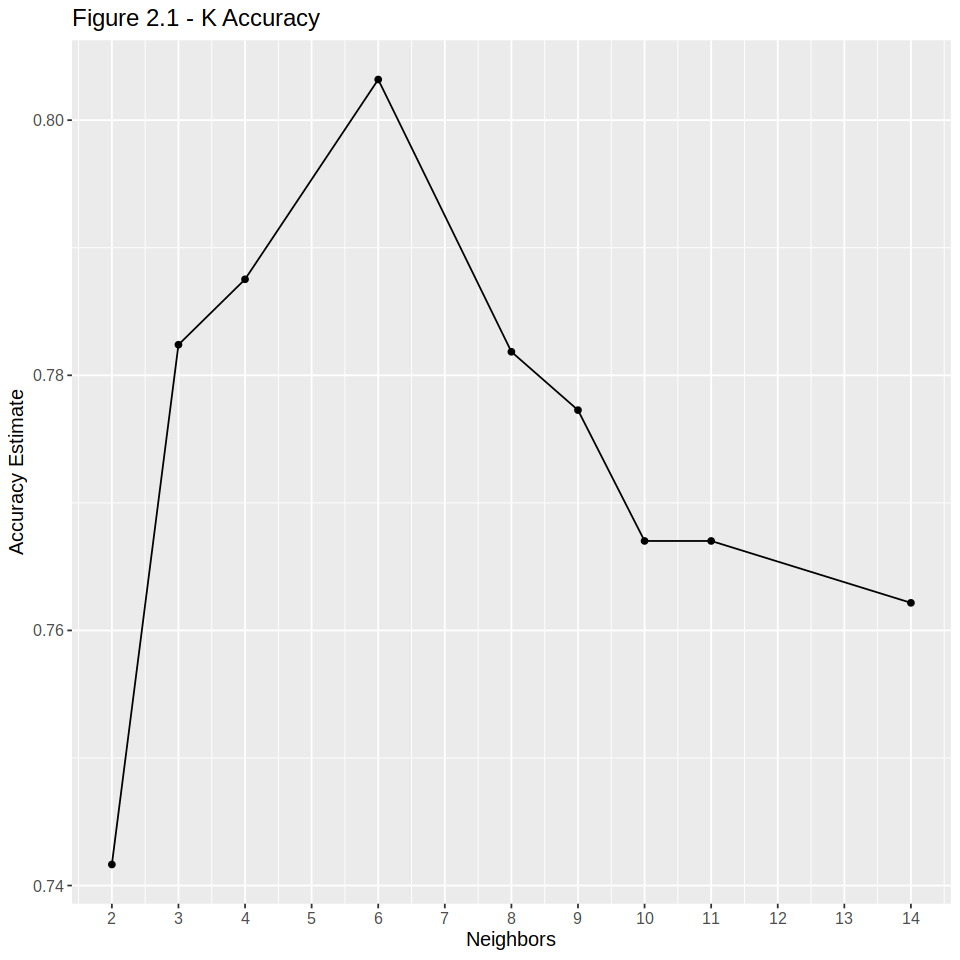

In [10]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") 

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +
    ggtitle("Figure 2.1 - K Accuracy")+ 
theme(text = element_text(size = 12))

options(repr.plot.width = 8, repr.plot.height = 8) 


accuracy_versus_k

Here we plot a graph based on the results we got from our model and its accuracy. This graph tells us how accurate is our model based on how many K-nearest neighbors it chooses. From this we can select how many neighbors our model should choose based on what point is the highest on the graph thus has highest accuracy. After analyzing this graph we selected 6 K-nearest neighbors. This is because compared to the rest it stands the highest on the graph and no other value has even a high enough accuracy to it. Also moving one up or down in the number of neighbors does not decrease the accuracy by much and the value is also generally low compared to rest so it does not create a prohibitively expensive computational cost of training. 

In [11]:
ux_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("classification") 

ux_fit <- workflow() |>
    add_recipe(ux_recipe) |>
    add_model(ux_spec) |>
    fit(data = ux_train)

ux_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1865285
Best kernel: rectangular
Best k: 6

Again, in our model we now used the 6 K -nearest neighbors value and it will provide us the highest accuracy.

In [20]:

ux_predictions <- ux_fit |>
    predict(ux_test) |>
    bind_cols(ux_test)

ux_metrics <- ux_predictions |>
    metrics(truth = knowledge, estimate = .pred_class) |>
    filter(.metric == "accuracy")

ux_conf_mat <- ux_predictions |>
    conf_mat(truth = knowledge, estimate = .pred_class)

h2("Figure 2.2 - Predictions")
head(ux_predictions)
h2("Figure 2.3 - Accuracy")
ux_metrics
h2("Figure 2.4 - Confusion Matrix ")
ux_conf_mat

Shiny tags cannot be represented in plain text (need html)

.pred_class,study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Low,1.0,1.0,1.5,6.5,3.0,Middle
Low,0.8,0.8,0.8,9.8,2.4,Low
Low,1.5,0.2,3.4,4.0,0.1,Very Low
High,1.8,1.8,5.5,3.0,8.1,High
Low,1.0,1.0,5.2,7.8,3.4,Middle
High,1.2,1.2,7.5,3.5,8.0,High


Shiny tags cannot be represented in plain text (need html)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7384615


Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction Very Low High Low Middle
  Very Low        0    0   0      0
  High            0   12   0      0
  Low             7    0  18      3
  Middle          0    6   1     18

Based on figure 2.3, the value for the accuracy of our model is around 0.738 meaning it is around 74%. This value can be further correlated to the confusion matrix where we can see how the predictions differed with the actual truth. We can see that majority of the predictions were true but there was still a decent amount of error as the low level had (7+3) 10 false predictions, middle had (6+1) 7 false. The high knowledge level turned out very good though as all of its predictions were 100% true. These results are due to the clusters explained in figure 1.0. The very top cluster stood by itself with mostly only very high knowledge levels which probably accounts for the  such high truth percentage of this knowledge level. The reason why there are some false predictions in the low and middle levels is because the other two clusters were more of a mix. One of them was mostly middle levels but there was some high levels mixed in them which is why most of the middle levels falses were high level. Similarly the other cluster was a mix of very low and low levels with some middle level points in there also. This is why low knowledge levels falses were actually very low and some were middle. One thing to notice is that 'very low' had 0 predictions. This probably due to the fact there was a small proportion of them in the training set which originally led up from the original data set having a small amount of very low knowledge levels

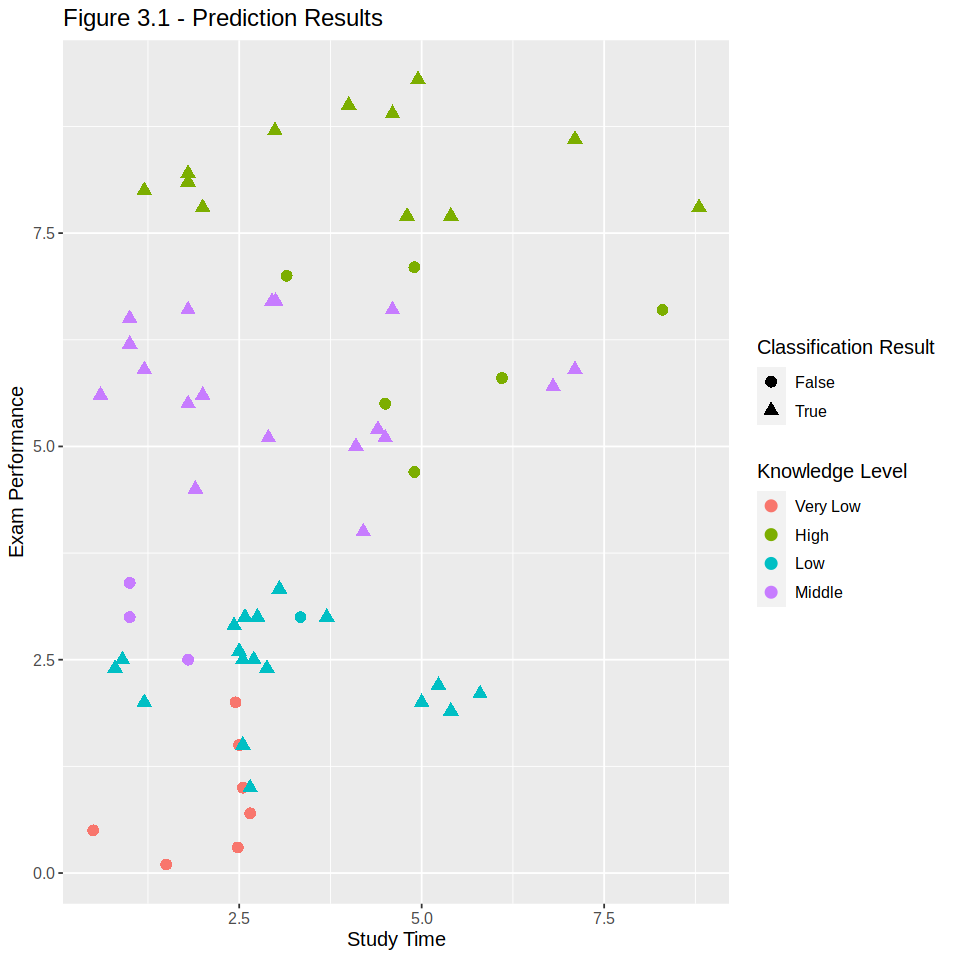

In [13]:
ux_accurate <- ux_predictions |>
    mutate(Truth = ifelse(.pred_class == knowledge, "True", "False"))

ux_plot <- ux_accurate |>
    ggplot(aes(x = study_time_goal, y = exam_performance_goal, color = knowledge, shape = Truth)) +
    geom_point(size = 3) +
    labs(x = "Study Time", y = "Exam Performance", color = "Knowledge Level", shape = "Classification Result") +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 3.1 - Prediction Results")+
    theme(text = element_text(size = 12))

options(repr.plot.width = 8, repr.plot.height = 8) 


ux_plot

In the final part of our analysis we plot a graph to represent our predictions. These plots are based off whats the correct knowledge level was of each prediction and if it was correct or not. The shape for Classification results helps us visualize out of all the predictions how does the correctness/truthfulness of them vary.

Shiny tags cannot be represented in plain text (need html)

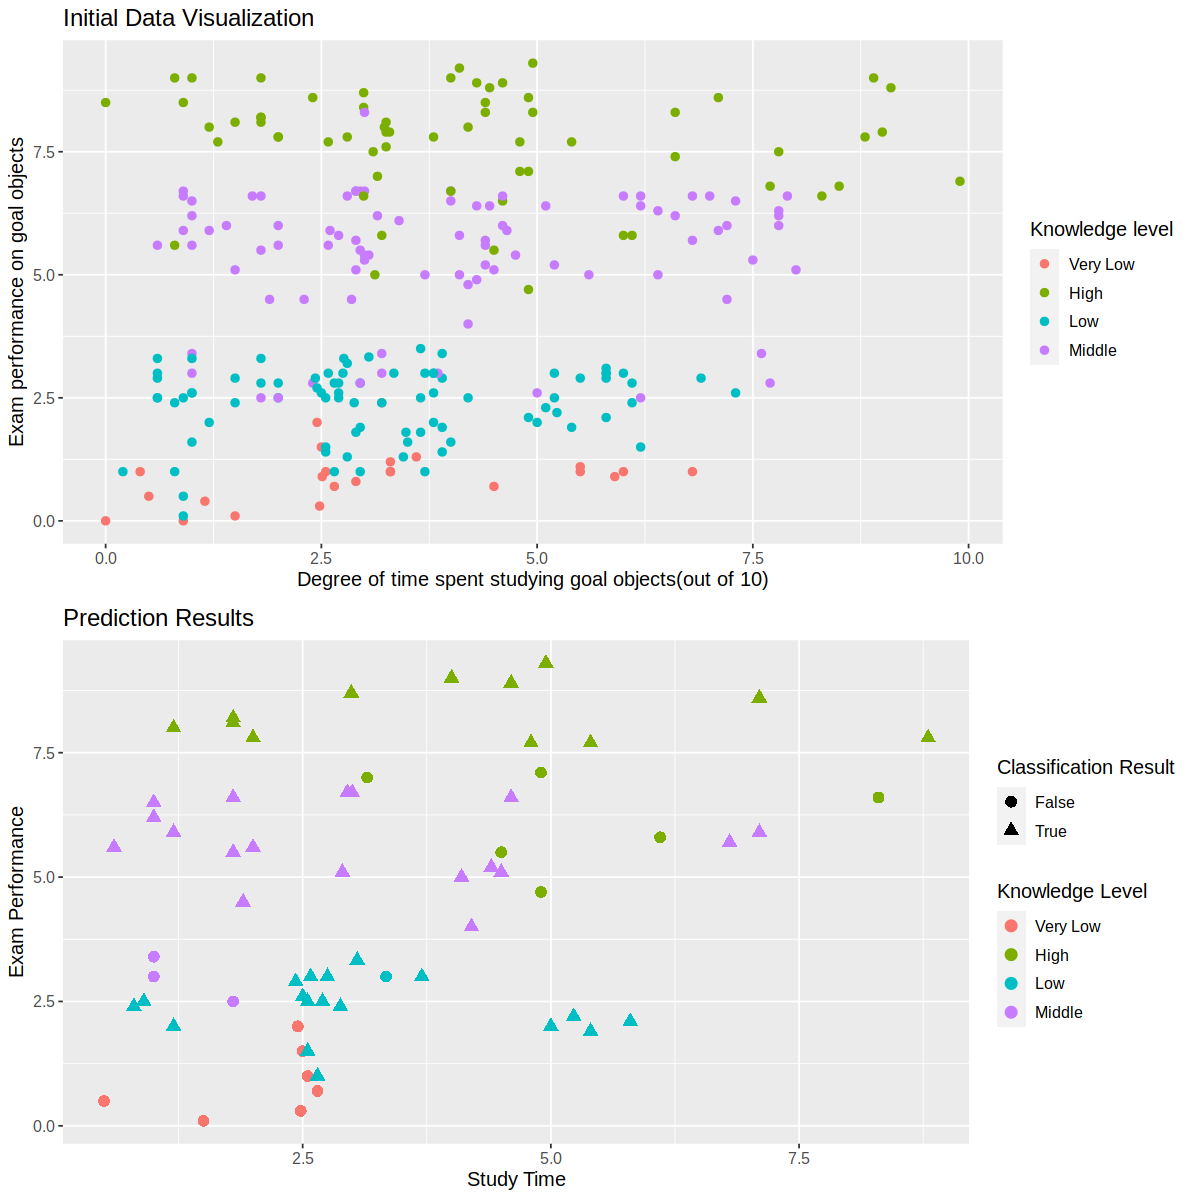

In [21]:
ux_plot1 <- ux_accurate |>
    ggplot(aes(x = study_time_goal, y = exam_performance_goal, color = knowledge, shape = Truth)) +
    geom_point(size = 3) +
    labs(x = "Study Time", y = "Exam Performance", color = "Knowledge Level", shape = "Classification Result") +
    theme(text = element_text(size = 10)) +
    ggtitle("Prediction Results")+
    theme(text = element_text(size = 12))

options(repr.plot.width = 10, repr.plot.height = 10) 


ux_plot_initial1 <- ggplot(tidy_ux_data, aes(x = study_time_goal, y = exam_performance_goal, color = knowledge)) +
    geom_point(size=2) +
    labs(x = "Degree of time spent studying goal objects(out of 10)", 
        y = "Exam performance on goal objects", 
        color = "Knowledge level") +
    ggtitle("Initial Data Visualization")+
    theme(text = element_text(size = 12))

h2("Figure 3.2 - Comparison")
grid.arrange(ux_plot_initial1, ux_plot1, ncol=1)

We decided to plot our original graph which beside the graph based on the predictions so that we could compare our results to our expected outcome and prediction based on figure 1.0. They are similar in the way that they have the same amount of clusters(3) and have the same type of knowledge levels in each cluster. But one thing different about them is the distribution of them for example the bottom cluster in the original graph is distributed across all study times while the one with the predictions is limited to a lower study time.

## Discussion

## Summary of findings
By comparing the initial anticipated results to the actual results, it is obvious that the study was successful in establishing a correlation between students' study habits and exam scores. The original goal was to find patterns that may predict students' knowledge levels based on exam outcomes and study time. The study's hypothesis was that if students spent more time studying specified materials (STG) and performed better on exams relevant to target items (PEG), it would lead to higher knowledge levels.

The user experience data is cleaned and transformed before the exploratory data analysis starts. Following the extraction of pertinent information from the 258 cases in the dataset, the knowledge levels are divided into four categories: Very Low, Low, Middle, and High. Study time for goal object materials (STG) and test performance for goal objects (PEG) are the main predictor variables chosen for analysis.
The initial scatter plot display of the data (Figure 1.0) reveals three distinct clusters, indicating a likely relationship among knowledge levels, exam performance, and study time. These clusters reflect high, medium, and mixed low/very low knowledge levels. The data is then divided into training and testing sets in order to build the model.

To get the maximum possible accuracy, the number of neighbors (K) in the K-Nearest Neighbors (KNN) classification model is chosen through a tuning process.  The final model's six neighbors are chosen based on the accuracy-versus-K plot (Figure 2.1). The KNN model is evaluated using training data, producing an accuracy of about 74% (Figure 2.3).

The confusion matrix (Figure 2.4) shows areas of accurate and inaccurate predictions and offers insights into the model's performance across various knowledge levels. The 'very low' knowledge level, presumably as a result of its little representation in the training set, was notable for having no predictions.

Compared to figure 1.0, our final analysis (figure 3.1) is similar in how the clusters are formed. In the plot based on our prediction model we can see there are three clusters, one with high knowledge level points, one with mostly middle level and some high level points and the final one being a mix of mostly low level but some very low and middle in it. Based on our question,"Is it possible to predict students' knowledge based on their exam scores and study habits?" We expected to see how the study habits and their exam scores correlate with knowledge level. Based on study habits alone, around after the value of 5 for study time, there are a majority only high knowledge level points with some middle and couple low level. This indicates that there is some correlation of higher study time leads to higher knowledge but we cannot neglect the other points on the graph which depict that pushing for more studying does not always lead to a student acquiring more knowledge. Also the third cluster is in the bottom left corner which means most of the points have a low study time and also low exam scores. All these points are mostly low or very low knowledge levels which presents that not studying enough and thus performing low on exams leads to low knowledge acquisition. The analysis of exam performance variables is super clear and simple from this plot. As the exam scores increase, the color of the plots thus the knowledge levels also increase. This means that performing well on your exams correlates to a student gaining more knowledge from their studies. In conclusion, generally increased study time does indicate higher knowledge but that is not always the case so this variable is not the strongest predictor for knowledge levels of students but exam performance was very clear in showing that doing well on tests means that the student had a good understanding and knowledge of what they learned.

We expected to find this because the plot of the original data showed similar clusters which illustrated that exam performance has a great impact on knowledge levels because similarly as exam performance increased, the knowledge levels did also. The only thing we did not expect was how study time was going to affect the knowledge because the points were very scattered in each cluster unlike the clusters in our models graph where the third cluster was compacted in the bottom left area.	




The study concludes by investigating the relationships between knowledge levels, study habits, and exam scores. Although the KNN classification model appears to be promising, more research and analysis are needed to properly understand the effects of study habits on knowledge acquisition. The data analysis method may be repeated with different samples, which would improve the efficiency of our results, minimizing the effects of any lurking variables or other underlying factors. 

## Impacts
The results of the study may have an impact on how teachers grade and assess their students. The study may support current assessment methods if it finds a significant relationship between exam results and study habits. If not, it might encourage teachers to reevaluate the significance of conventional tests and look into alternate evaluation techniques that offer a more realistic picture of students' understanding. A deeper awareness of the correlation between exam performance and study habits might be advantageous for both parents and students. Making better judgments about how to approach education, including devoting more time to productive study techniques, can result from having this knowledge.

Teachers could use this data to create individualized study plans and intervention strategies for students across different levels. For example, specific measures aimed at enhancing time management and study habits could improve knowledge acquisition for students in the group who score poorly on exams and have little study time. Meanwhile, strategies focused on optimizing study efficiency might be helpful for those in the cluster with high study time and varying knowledge levels.

Moreover, the evident association between exam results and knowledge levels emphasizes how important assessments are in determining students' comprehension. Academic institutions may want to think about improving their assessment techniques and offering more assistance to students who are having difficulty performing well on exams.


## Further Questions
Are there any lurking variables? (such as students going to tutoring services or students taking the course again): 
Assessing knowledge based on students' exam results and their study time can be impacted by  lurking variables, such as students who repeat courses or look for tutoring. These variables can introduce factors which could affect the outcome. For example, students who attend tutoring sessions could have better exam results that are influenced by the tutoring they receive as well as their study habits. It is necessary to identify and take into consideration these hidden factors in order to guarantee an accurate  evaluation of students' knowledge.

  
Are there qualitative aspects of studying such as studying habits that we haven’t considered?:
It's critical to take into account qualitative aspects of learning beyond test results when assessing students. For example students learn and study better when they have prior knowledge to bring into new learning(Taylor, 2023). Study habits, learning strategies, and critical thinking abilities are important qualitative factors that are often overlooked in favor of quantitative results when using traditional metrics. Ignoring these factors could result in an inaccurate assessment of how well a student understands and applies the material. Including qualitative data can give educators a more comprehensive picture by enabling them to evaluate students' knowledge as well as their ability to apply it in a variety of situations.


Would findings be different with a newer dataset?:
The timeliness of the dataset can affect how relevant and accurate it is to evaluate students' knowledge based on exam results and study habits. More recent datasets may show changing trends in education, adjustments to curriculum, or adjustments to teaching methods. To make sure that results accurately depict the context of education today and the most recent data regarding students' learning experiences and outcomes, a more recent dataset should be analyzed.


How can educators and institutions effectively teach and promote better study habits among students?: 
If studying a lot and doing well on exams does not correlate to ‘high knowledge’ it could raise the question if teachers need to approach their education methods in a different way. Teachers mostly emphasize studying and doing well on the assessments, trying to make their students more knowledgeable people but the whole approach of this would need to be changed if none of them even helps them in acquiring knowledge. This analysis and research has found that tests can be valuable tools to help students learn(Berwick, 2019) so this basis can be used to see if studying more allows for higher knowledge.





## Bibliography

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.

Berwick, C. (2019, October 25). What does the research say about testing?. Edutopia. https://www.edutopia.org/article/what-does-research-say-about-testing/ 

Taylor, J. (2023, August 14). What is the relationship between learning and knowledge?. Great Minds®: Math, English, and Science Curriculum Developers. https://greatminds.org/aha-blog/what-is-the-relationship-between-learning-and-knowledge#:~:text=Students%20learn%20better%20when%20they,a%20coherent%20manner. 